In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave


backend.set_learning_phase(1) #set learning phase

Using TensorFlow backend.


In [2]:
# These represent some easily changable numbers: weights, number of iterations, and I/O
content_weight = 0.01
style_weight = 40
total_variation_weight = 3
iterations = 40
# Orginal 0.025, 20, 3

# Beginning of filename to save the output. We later append the style, content, and total 
# weights to the end of the filename.
filename_orig = "inception_Filis_as_daVinci_highRes_iter40_style"
content_image_path = 'images/Filis_daVinciCrop.jpg'
style_image_path = 'images/DaVinci.jpg'


# Content definition:
#content_layers = 'input_2'

# Style definition: Sum of Gram matrix of the following layers
# feature_layers = ['mixed0', 'mixed1', 'mixed2', 'mixed3', 'mixed4', 'mixed5', 
#                   'mixed6', 'mixed7', 'mixed8', 'mixed9_0', 'concatenate_7', 
#                   'mixed9', 'mixed9_1', 'concatenate_8', 'mixed10']
feature_layers = ['mixed0', 'mixed1', 'mixed4', 
                  'mixed7', 'mixed9_0', 'mixed9', 'mixed9_1', 'mixed10']

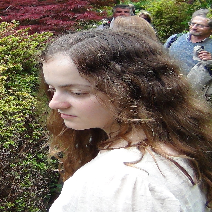

In [3]:
height = 212
width = 212

#content_image_path = 'images/hugo.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

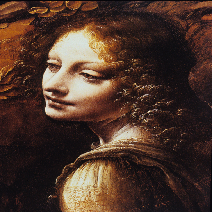

In [4]:
#style_image_path = 'images/styles/wave.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

In [5]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

content_array = preprocess_input(content_array)
style_array = preprocess_input(style_array)

(1, 212, 212, 3)
(1, 212, 212, 3)


In [6]:
# Now we're ready to use these arrays to define variables in Keras' backend (the TensorFlow graph).
# We also introduce a placeholder variable to store the combination image that retains the content 
# of the content image while incorporating the style of the style image.
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

# Finally, we concatenate all this image data into a single tensor that's suitable for processing by Keras' VGG16 model.
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [7]:
model = InceptionV3(input_tensor=input_tensor, weights='imagenet',
                  include_top=False)
    
layers = dict([(layer.name, layer.output) for layer in model.layers])
print(layers.keys())
len(layers.keys())

dict_keys(['input_1', 'conv2d_1', 'batch_normalization_1', 'activation_1', 'conv2d_2', 'batch_normalization_2', 'activation_2', 'conv2d_3', 'batch_normalization_3', 'activation_3', 'max_pooling2d_1', 'conv2d_4', 'batch_normalization_4', 'activation_4', 'conv2d_5', 'batch_normalization_5', 'activation_5', 'max_pooling2d_2', 'conv2d_9', 'batch_normalization_9', 'activation_9', 'conv2d_7', 'conv2d_10', 'batch_normalization_7', 'batch_normalization_10', 'activation_7', 'activation_10', 'average_pooling2d_1', 'conv2d_6', 'conv2d_8', 'conv2d_11', 'conv2d_12', 'batch_normalization_6', 'batch_normalization_8', 'batch_normalization_11', 'batch_normalization_12', 'activation_6', 'activation_8', 'activation_11', 'activation_12', 'mixed0', 'conv2d_16', 'batch_normalization_16', 'activation_16', 'conv2d_14', 'conv2d_17', 'batch_normalization_14', 'batch_normalization_17', 'activation_14', 'activation_17', 'average_pooling2d_2', 'conv2d_13', 'conv2d_15', 'conv2d_18', 'conv2d_19', 'batch_normalizatio

311

In [8]:
mix_layer = []
concat = []
for layer in layers.keys():
    if (("mix" in layer) or ("concat" in layer)):
        mix_layer.append(layer)
        
    if "concat" in layer:
        concat.append(layer)
        
print(mix_layer)
print(concat)
#feature_layers.extend(concat)
content_layers = list(layers.keys())[0]

['mixed0', 'mixed1', 'mixed2', 'mixed3', 'mixed4', 'mixed5', 'mixed6', 'mixed7', 'mixed8', 'mixed9_0', 'concatenate_1', 'mixed9', 'mixed9_1', 'concatenate_2', 'mixed10']
['concatenate_1', 'concatenate_2']


In [9]:
# initiazlie the loss variable
loss = backend.variable(0.)

# Content loss
# block2_conv2
def content_loss(content, combination):
    return backend.sum(backend.square(np.sqrt(content_weight)*combination - np.sqrt(content_weight)*content))

# layer_features defines the "content" 
# original: layer_features = layers['block2_conv2']
layer_features = layers[content_layers]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_loss(content_image_features, combination_features)

# Style loss
# Combine:
# block1_conv2, block2_conv2, block3_conv3, block4_conv3, block5_conv3
# The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(np.sqrt(style_weight)*S - np.sqrt(style_weight)*C)) / (4. * (channels ** 2) * (size ** 2))

# feature_layers defines the "style" of an image
# original:

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (1. / len(feature_layers)) * sl
    
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)


grads = backend.gradients(loss, combination_image)

outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    filename = "Example" + str(i) + ".jpg"
    #save_image(x,name=filename, iteration=i)
    
    
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

# x = x.reshape((height, width, 3))
# x = x[:, :, ::-1]
x /= 2.
x += 0.5
x *= 255

A = Image.fromarray(x)
filename = filename_orig
filename += str(style_weight) + "_total" + str(total_variation_weight) + "_content" + str(content_weight) + "origSize" + ".jpg"
A.save(filename)
#Image.fromarray(x)

from scipy.misc import imresize
#from skimage.transform import resize
orig_im = np.array(Image.open(content_image_path))
x = imresize(x, orig_im.shape)
B = Image.fromarray(x)
filename = filename_orig
filename += str(style_weight) + "_total" + str(total_variation_weight) + "_content" + str(content_weight) + ".jpg"
B.save(filename)

Image.fromarray(x)

Start of iteration 0
